# Macro-data-prepare.ipynb

各種経済指標を取得する


In [1]:
%load_ext autoreload
%autoreload 2

import sqlite3
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from google_drive_utils import upload_file_to_drive

ROOT_DIR = Path().cwd().parent
DATA_DIR = ROOT_DIR / "data"
ECO_DIR = DATA_DIR / "Economic Indicators"
BBG_DIR = DATA_DIR / "Bloomberg"
FRED_DIR = DATA_DIR / "FRED"
INDEX_DIR = DATA_DIR / "Factset" / "Index"

## Baltic Dry Index


In [ ]:
# データはInvesting.comとかから手動で収集
file_list = list(ECO_DIR.glob("Baltic Dry Index/*.csv"))
upload_file_to_drive(file_list, "13_Quants/data/Baltic Dry Index")

フォルダ '13_Quants' を見つけました (ID: 1lVJMUgTWZXELZTCeeDQ_zMSNx7yiC1AJ)
フォルダ 'data' を見つけました (ID: 17U7Od658xMzhLTQtQk6J5DGM1stU4ebV)
フォルダ 'Baltic Dry Index' を見つけました (ID: 193TNgCqNfNBGV86I4K9h2o6e1UAedWQj)

アップロード処理開始: /Users/yukihata/Desktop/papers/Quants/data/Economic Indicators/Baltic Dry Index/Baltic Dry Index 過去データ (2).csv
  -> ✅ アップロード完了 (File ID: 1x81aB8KKL_KbVPTClceiUmCMFB9qFg91)

アップロード処理開始: /Users/yukihata/Desktop/papers/Quants/data/Economic Indicators/Baltic Dry Index/Baltic Dry Index 過去データ (3).csv
  -> ✅ アップロード完了 (File ID: 1U3yul7U9PU_9ZqgI7xhSaA-bTcHW9d2V)

アップロード処理開始: /Users/yukihata/Desktop/papers/Quants/data/Economic Indicators/Baltic Dry Index/Baltic Dry Index 過去データ.csv
  -> ✅ アップロード完了 (File ID: 1Gn1zI7W7iMNDNFWM7LXVTlaULZT34RY8)

アップロード処理開始: /Users/yukihata/Desktop/papers/Quants/data/Economic Indicators/Baltic Dry Index/Baltic Dry Index 過去データ (1).csv
  -> ✅ アップロード完了 (File ID: 1slaWKhD7gnrkS2l1mw_rrL-WwpzWXpML)


In [ ]:
dfs = []
for f in file_list[:1]:
    df = (
        pd.read_csv(f)
        .drop(columns=["変化率 %"])
        .rename(
            columns={
                "日付け": "date",
                "終値": "close",
                "始値": "open",
                "高値": "high",
                "安値": "low",
                "出来高": "volume",
            }
        )
        .assign(date=lambda row: pd.to_datetime(row["date"]))
    )
    dfs.append(df)

df = (
    pd.melt(pd.concat(dfs, ignore_index=True), id_vars="date", value_name="value")
    .assign(Index="Baltic Dry Index")
    .reindex(columns=["date", "Index", "variable", "value"])
)

db_path = ECO_DIR / "Economic-Indicators.db"
conn = sqlite3.connect(db_path)
df.to_sql("Baltic Dry Index", con=conn, index=False, if_exists="replace")
conn.close()

upload_file_to_drive([db_path], "13_Quants/data/Economic Indicators")

フォルダ '13_Quants' を見つけました (ID: 1lVJMUgTWZXELZTCeeDQ_zMSNx7yiC1AJ)
フォルダ 'data' を見つけました (ID: 17U7Od658xMzhLTQtQk6J5DGM1stU4ebV)
フォルダ 'Economic Indicators' を見つけました (ID: 1pFF-v5KFUmmd0CUHBYrK8__MZJxABBol)

アップロード処理開始: /Users/yukihata/Desktop/papers/Quants/data/Economic Indicators/Economic-Indicators.db
  -> ✅ アップロード完了 (File ID: 1TjwSZMfflkeKy0U_VxP4xRvUxBxLEM9m)


## Bloomberg

-   ISM-PMI


In [ ]:
df = pd.read_parquet(BBG_DIR / "Bloomberg_ISM-PMI.parquet")
df["date"] = pd.to_datetime(df["date"])

db_path = BBG_DIR / "Bloomberg.db"
conn = sqlite3.connect(db_path)

df_ticker = pd.read_json(BBG_DIR / "ticker-description.json")[
    ["bloomberg_ticker", "name"]
].rename(columns={"bloomberg_ticker": "Index"})
df = (
    pd.merge(df, df_ticker, on=["Index"], how="left")
    .drop(columns=["Index"])
    .rename(columns={"name": "Index"})
).reindex(columns=["date", "Index", "value"])

df.to_sql("ISM_PMI_Survey", con=conn, index=False, if_exists="replace")
conn.close()

display(df)

,date,Index,value
0,1948-01-31,Manufacturing/Inventory Levels,45.3000
1,1948-01-31,Manufacturing/Employment,54.8000
2,1948-01-31,ISM Manufacturing PMI SA,51.7000
3,1948-01-31,Manufacturing/New orders,53.3000
4,1948-01-31,Manufacturing/Production and Business Activity,59.1000
...,...,...,...
6715,2025-09-10,ISM Services PMI,52.0000
6716,2025-09-10,Services/Prices,69.2000
6717,2025-09-10,ISM Manufacturing PMI SA,48.7000
6718,2025-09-10,Manufacturing/Inventory Levels,49.4000


-   MSCI Kokusai Index


In [ ]:
db_path = INDEX_DIR / "Index-Price-and-Valuation.db"
conn = sqlite3.connect(db_path)
query = """
    select
        date, value, `Index`
    from
        FG_PRICE
    where
        `Index` in ('MSCI Kokusai Index (World ex Japan)', 'MSCI Kokusai Index (World ex Japan) Growth', 'MSCI Kokusai Index (World ex Japan) Value', 'MSCI Kokusai Quality')
"""
df_price = (
    pd.read_sql(
        query,
        con=conn,
    )
    .pivot(index="date", columns="Index", values="value")
    .sort_index()
)
df_price.columns = [
    s.replace(" Index (World ex Japan)", "") for s in df_price.columns.tolist()
]
df_price.index = pd.to_datetime(df_price.index)

start_date = pd.to_datetime("2006-01-01")

df_price = df_price.loc[start_date:, :]
df_log_return = np.log(df_price) - np.log(df_price.shift())
df_log_return = df_log_return.fillna(0)
df_cum_return = np.exp(df_log_return.cumsum())
df_cum_return["Growth - Kokusai"] = df_cum_return["MSCI Kokusai Growth"].sub(
    df_cum_return["MSCI Kokusai"]
)
df_cum_return["Quality - Kokusai"] = df_cum_return["MSCI Kokusai Quality"].sub(
    df_cum_return["MSCI Kokusai"]
)
df_cum_return["Quality - Growth"] = df_cum_return["MSCI Kokusai Quality"].sub(
    df_cum_return["MSCI Kokusai Growth"]
)
display(df_log_return)
display(df_cum_return)

,MSCI Kokusai,MSCI Kokusai Growth,MSCI Kokusai Value,MSCI Kokusai Quality
date,,,,
2006-01-03,0.000000,0.000000,0.000000,0.000000
2006-01-04,0.009806,0.010900,0.008704,0.008642
2006-01-05,-0.001170,-0.001246,-0.001093,-0.000768
2006-01-06,0.009848,0.010610,0.009080,0.009324
2006-01-09,0.000728,0.000994,0.000459,0.002851
...,...,...,...,...
2025-09-03,0.004748,0.011538,-0.002782,0.010075
2025-09-04,0.007203,0.008169,0.006123,0.007801
2025-09-05,-0.000627,-0.001279,0.000101,-0.002568


,MSCI Kokusai,MSCI Kokusai Growth,MSCI Kokusai Value,MSCI Kokusai Quality,Growth - Kokusai,Quality - Kokusai,Quality - Growth
date,,,,,,,
2006-01-03,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
2006-01-04,1.009854,1.010959,1.008742,1.008679,0.001105,-0.001175,-0.002280
2006-01-05,1.008674,1.009701,1.007641,1.007905,0.001027,-0.000769,-0.001796
2006-01-06,1.018656,1.020470,1.016832,1.017346,0.001814,-0.001310,-0.003124
2006-01-09,1.019398,1.021485,1.017299,1.020250,0.002087,0.000853,-0.001235
...,...,...,...,...,...,...,...
2025-09-03,3.502041,5.838962,1.978673,5.740564,2.336921,2.238523,-0.098398
2025-09-04,3.527357,5.886857,1.990825,5.785522,2.359500,2.258165,-0.101335
2025-09-05,3.525145,5.879333,1.991027,5.770686,2.354188,2.245541,-0.108647


-   US Bond Interest Rate


In [ ]:
db_path = BBG_DIR / "Bloomberg.db"
conn = sqlite3.connect(db_path)
df = pd.read_sql("SELECT * FROM ISM_PMI_Survey", con=conn)
conn.close()

db_path = FRED_DIR / "FRED.db"
conn = sqlite3.connect(db_path)
df_yield = pd.read_sql("SELECT * FROM T10Y2Y", con=conn, index_col="date").assign(
    T10Y2Y_EMA=lambda row: row["T10Y2Y"].ewm(span=126, adjust=False).mean()
)
df_yield.index = pd.to_datetime(df_yield.index)
df_yield.sort_index(inplace=True)
conn.close()
display(df_yield)

df["date"] = pd.to_datetime(df["date"])
df = df[
    df["Index"].isin(
        ["ISM Manufacturing PMI SA", "ISM Services PMI", "ISM PMI Surveys"]
    )
]
df = pd.pivot(df, index="date", columns="Index", values="value").assign(
    ISM_PMI_EMA=lambda row: row["ISM PMI Surveys"].ewm(span=6, adjust=False).mean(),
    Manufacturing_EMA=lambda row: row["ISM Manufacturing PMI SA"]
    .ewm(span=6, adjust=False)
    .mean(),
    Service_EMA=lambda row: row["ISM Services PMI"].ewm(span=6, adjust=False).mean(),
)

display(df)

,T10Y2Y,T10Y2Y_EMA
date,,
1976-06-01,0.68,0.680000
1976-06-02,0.71,0.680472
1976-06-03,0.70,0.680780
1976-06-04,0.77,0.682185
1976-06-07,0.79,0.683883
...,...,...
2025-09-15,0.51,0.475827
2025-09-16,0.53,0.476681
2025-09-17,0.54,0.477678


Index,ISM Manufacturing PMI SA,ISM PMI Surveys,ISM Services PMI,ISM_PMI_EMA,Manufacturing_EMA,Service_EMA
date,,,,,,
1948-01-31,51.7,NaN,NaN,NaN,51.700000,NaN
1948-02-29,50.2,NaN,NaN,NaN,51.271429,NaN
1948-03-31,43.3,NaN,NaN,NaN,48.993878,NaN
1948-04-30,45.4,NaN,NaN,NaN,47.967055,NaN
1948-05-31,49.5,NaN,NaN,NaN,48.405040,NaN
...,...,...,...,...,...,...
2025-05-31,48.5,49.7614,49.9,51.333738,48.919443,51.604044
2025-06-30,49.0,50.6254,50.8,51.131356,48.942459,51.374317
2025-07-31,48.0,49.8963,50.1,50.778483,48.673185,51.010227


### Plot


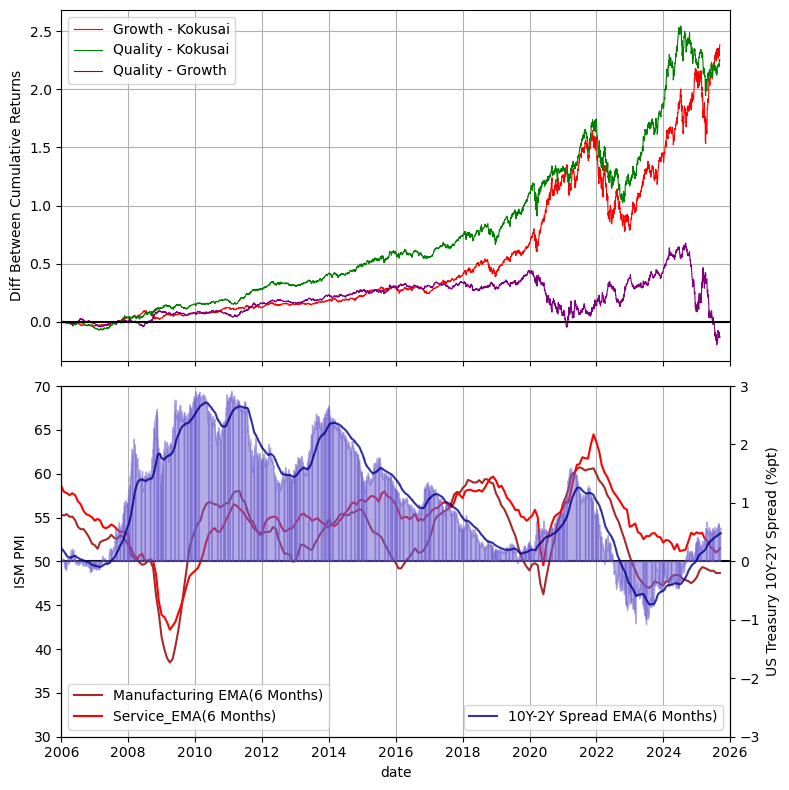

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True, tight_layout=True)
# sns.lineplot(
#     df, x=df.index, y=df["ISM PMI Surveys"], ax=ax, label="ISM PMI", color="orange"
# )
# sns.lineplot(
#     df,
#     x=df.index,
#     y=df["ISM_PMI_EMA"],
#     ax=ax,
#     label="ISM PMI EMA(6 Months)",
#     color="orange",
# )

ax0 = axes[0]
# for col in df_cum_return.columns:
#     linecolor = "black"
#     if "Growth" in col:
#         linecolor = "red"
#     elif "Value" in col:
#         linecolor = "blue"
#     elif "Quality" in col:
#         linecolor = "green"
#     sns.lineplot(
#         df_cum_return,
#         x=df_cum_return.index,
#         y=df_cum_return[col],
#         label=col,
#         ax=ax0,
#         linewidth=0.8,
#         color=linecolor,
#     )
sns.lineplot(
    data=df_cum_return,
    x=df_cum_return.index,
    y=df_cum_return["Growth - Kokusai"],
    label="Growth - Kokusai",
    color="red",
    linewidth=0.8,
    ax=ax0,
)
sns.lineplot(
    data=df_cum_return,
    x=df_cum_return.index,
    y=df_cum_return["Quality - Kokusai"],
    label="Quality - Kokusai",
    color="green",
    linewidth=0.8,
    ax=ax0,
)
sns.lineplot(
    data=df_cum_return,
    x=df_cum_return.index,
    y=df_cum_return["Quality - Growth"],
    label="Quality - Growth",
    color="purple",
    linewidth=0.8,
    ax=ax0,
)
ax0.grid()
ax0.set_ylabel("Diff Between Cumulative Returns")
ax0.axhline(y=0, color="black")
ax0.legend(loc="upper left")

ax1 = axes[1]
sns.lineplot(
    df,
    x=df.index,
    y=df["Manufacturing_EMA"],
    ax=ax1,
    label="Manufacturing EMA(6 Months)",
    color="brown",
)
sns.lineplot(
    df,
    x=df.index,
    y=df["Service_EMA"],
    ax=ax1,
    label="Service_EMA(6 Months)",
    color="red",
)
ax1.set_ylim(30, 70)
ax1.axhline(50, color="black")
ax1.set_ylabel("ISM PMI")
ax1.legend(loc="lower left")
ax1.grid(axis="x")

ax2 = ax1.twinx()
ax2.fill_between(
    x=df_yield.index, y1=df_yield["T10Y2Y"], y2=0, color="slateblue", alpha=0.5
)
sns.lineplot(
    data=df_yield,
    x=df_yield.index,
    y=df_yield["T10Y2Y_EMA"],
    alpha=0.8,
    label="10Y-2Y Spread EMA(6 Months)",
    color="darkblue",
)
ax2.set_ylim(-3, 3)
ax2.set_ylabel("US Treasury 10Y-2Y Spread (%pt)")
ax2.set_xlim(start_date, pd.to_datetime("2026-01-01"))
ax2.legend(loc="lower right")

plt.show()

### 考察

-   金利スプレッドが広がってスティープニング**し始めた**2020~2021 年頃と 2024 年後半~2025 年まででは、クオリティ指数がグロース指数に劣後している（Quality - Growth のライン）。

### 次の分析

#### イールドカーブ PCA

-   スプレッドだけだと分かりにくい。PCA で level 主成分と slope 主成分の推移を重ね合わせることにする。
-   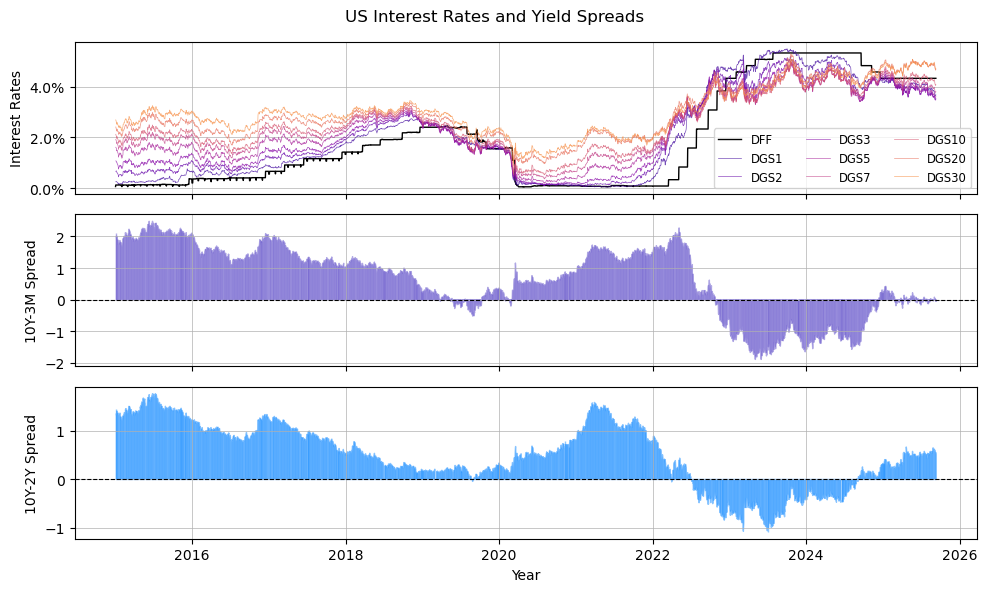

#### GEP port、LIST port VS Kokusai Index

-   個別銘柄の銘柄選択寄与度を時系列で可視化する。
